In [ ]:
# 경고 무시
import warnings
warnings.simplefilter('ignore')

# 자주 사용하는 패키지를 임포트
import matplotlib as mpl
import matplotlib.font_manager as fm

import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import numpy as np
import scipy as sp
import pandas as pd
import statsmodels.api as sm
import sklearn as sk
import scipy.stats


# matplotlib 설정
mpl.use('Agg')

# seaborn 설정
sns.set()
sns.set_style("whitegrid")
sns.set_color_codes()

%matplotlib inline

from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso, LinearRegression, LogisticRegression

from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split, ShuffleSplit, StratifiedKFold, cross_validate, learning_curve, GridSearchCV, KFold

import re
import sklearn

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC

from sklearn.preprocessing import label_binarize
import missingno as msno
from datetime import timedelta
from datetime import datetime
import datetime as dt
from dateutil.parser import parse

In [2]:
# 데이터 불러오기
dataB = pd.read_csv("type_B_모바일 서비스 현황 EDA/mobileTrendDataset2.csv")

## 변수 설명
- yearID: 연도 구분 (Y1 다음년도가 Y2)
- weekIndex: 주차 1~52주
- rank: 해당 주차의 앱 순위
- appID: 앱 구분자
- uniqueInstall: 앱 설치자 수(중복 불포함)
- UU: 주간 이용자 수
- useRate: 설치자중 이용자 비율
- totalDuration: 총 이용시간(분)
- avgDuration: 이용자당 평균 이용시간(분)
- dayCounts: 이용자의 평균 접속일수
- genreID: 장르 구분

### 추가한 변수
- year: 연도
- day: 날짜

In [21]:
## 결측치 확인
## appID 기준 해당 행을 제거

dataB.isnull().sum()

## 결측치 제거
dataB = dataB.dropna()
dataB.tail()

,yearID,weekIndex,year,day,rank,appID,uniqueInstall,UU,useRate,totalDuration,avgDuration,dayCounts,genreID
10395,Y2,52,2020,2020-12-21,96,N1205,226304,121849,53.84,1333028,10.94,1.97,G05
10396,Y2,52,2020,2020-12-21,97,N0041,193899,120635,62.22,6850862,56.79,1.72,G01
10397,Y2,52,2020,2020-12-21,98,N1206,194187,120249,61.92,1548807,12.88,1.87,G05
10398,Y2,52,2020,2020-12-21,99,N0762,155373,119867,77.15,35263673,294.19,3.23,G10
10399,Y2,52,2020,2020-12-21,100,N0283,175982,119209,67.74,3886213,32.60,1.09,G04


In [22]:
#엑셀을 통해 기본적인 날짜를 생성
#날짜형식으로 변환
dataB['day'] = pd.to_datetime(dataB['day'])
dataB

,yearID,weekIndex,year,day,rank,appID,uniqueInstall,UU,useRate,totalDuration,avgDuration,dayCounts,genreID
0,Y1,1,2019,2019-01-01,1,N0001,7027982,6690166,95.19,1314483816,196.48,4.10,G01
1,Y1,1,2019,2019-01-01,2,N0002,8979953,6012020,66.95,598676952,99.58,4.09,G02
2,Y1,1,2019,2019-01-01,3,N0003,8527132,5475405,64.21,818737310,149.53,4.33,G03
3,Y1,1,2019,2019-01-01,4,N0004,5527188,2617074,47.35,116433622,44.49,3.02,G03
4,Y1,1,2019,2019-01-01,5,N0005,2733015,1920640,70.28,175892211,91.58,3.44,G03
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10395,Y2,52,2020,2020-12-21,96,N1205,226304,121849,53.84,1333028,10.94,1.97,G05
10396,Y2,52,2020,2020-12-21,97,N0041,193899,120635,62.22,6850862,56.79,1.72,G01
10397,Y2,52,2020,2020-12-21,98,N1206,194187,120249,61.92,1548807,12.88,1.87,G05
10398,Y2,52,2020,2020-12-21,99,N0762,155373,119867,77.15,35263673,294.19,3.23,G10


## 날짜
- 2019년 1월1일부터 2020년 12월21일까지의 특정 날짜를 생성하도록함

In [24]:
dataB.dtypes

yearID                   object
weekIndex                 int64
year                      int64
day              datetime64[ns]
rank                      int64
appID                    object
uniqueInstall             int64
UU                        int64
useRate                 float64
totalDuration             int64
avgDuration             float64
dayCounts               float64
genreID                  object
dtype: object

In [38]:
# 장르는 총 10가지
len(dataB["genreID"].unique())

10

In [39]:
#순위권에 1회이상 진입한 어플의 수는 1,205가지
len(dataB["appID"].unique())

1205

In [25]:
dataB.describe()

,weekIndex,year,rank,uniqueInstall,UU,useRate,totalDuration,avgDuration,dayCounts
count,10398.000000,10398.000000,10398.000000,1.039800e+04,1.039800e+04,10398.000000,1.039800e+04,10398.000000,10398.000000
mean,26.495191,2019.500096,50.496538,7.336599e+05,4.122286e+05,65.430315,6.264980e+07,134.418236,3.236886
std,15.006488,0.500024,28.867455,1.600381e+06,6.155618e+05,19.033853,1.368002e+08,161.121213,1.371476
min,1.000000,2019.000000,1.000000,7.908500e+04,7.689300e+04,1.040000,2.076700e+04,0.230000,1.000000
25%,13.250000,2019.000000,25.250000,2.203375e+05,1.311490e+05,52.962500,5.152153e+06,28.352500,2.070000
50%,26.000000,2020.000000,50.500000,3.451045e+05,1.982480e+05,66.470000,1.849818e+07,81.450000,3.170000
75%,39.000000,2020.000000,75.000000,5.937562e+05,3.805728e+05,79.830000,5.556748e+07,174.555000,4.300000
max,52.000000,2020.000000,100.000000,2.431204e+07,6.690166e+06,100.000000,1.763252e+09,1437.490000,7.000000


<AxesSubplot:title={'center':'Pearson Correlation of Features'}>

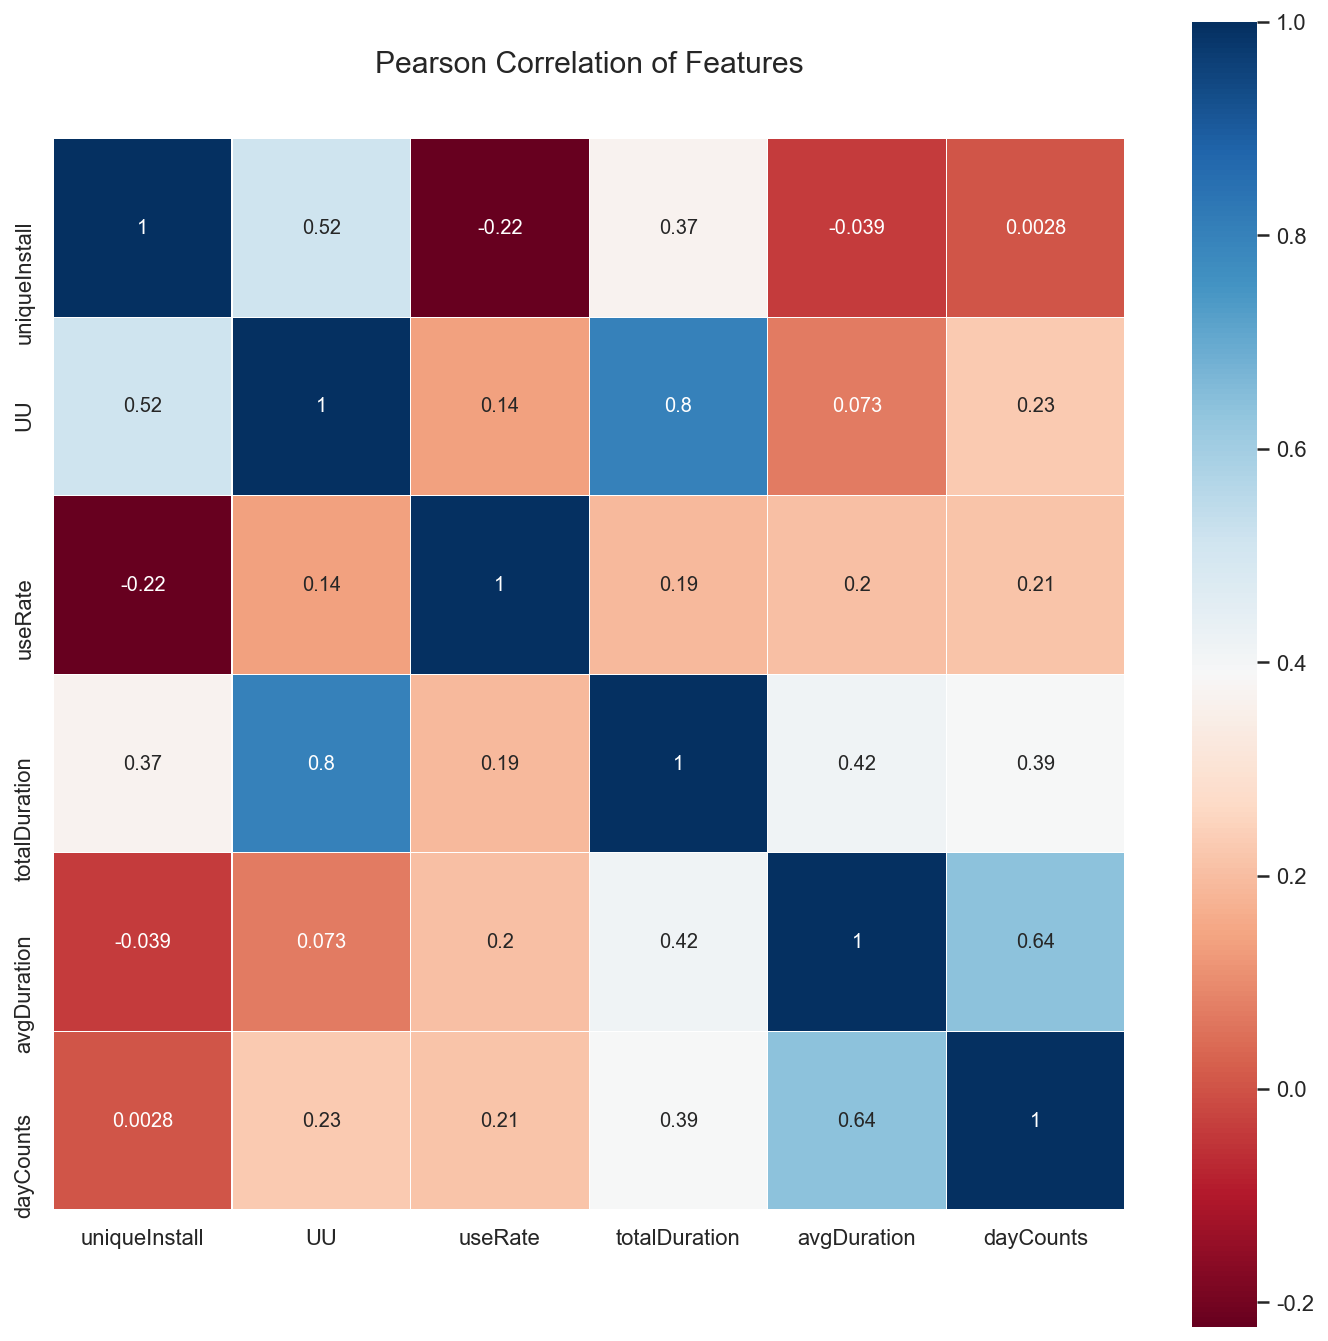

In [79]:
#상관계수 히트맵

colormap = plt.cm.RdBu
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(dataB[["uniqueInstall","UU","useRate","totalDuration","avgDuration","dayCounts"]].corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

## 상관관계
- UU와 totalDuration은 0.8의 가장 높은 상관관계를 가진다.
- avgDuration과 dayCounts 역시 0.64의 높은 상관관계를 보인다.
- 이외에도 UU와 uniqueInstall, totalDuration과 avgDuration, totalDuration과 dayCounts도 높은 양의 상관관계를 가진다.
- 음의 상관관계가 가장 높은 변수는 useRate와 uniqueInstall이다.

## 위 상관관계 해석
- 어떤 어플의 주간 이용자수가 많을수록 총 이용시간이 높을 것이다.
- 어떤 어플의 이용자당 평균 이용시간이 많을수록 이용자의 평균 접속일 수가 많을 것이다.
- 어떤 어플의 설치자 중 이용자 비율이 높을수록 중복을 포함하지 않은 앱 설치자 수가 적을 것이다. 즉, 어떤 충성도 높은 어플은 생각보다 앱설치자 수가 적을 것(밀도가 높음)이다.

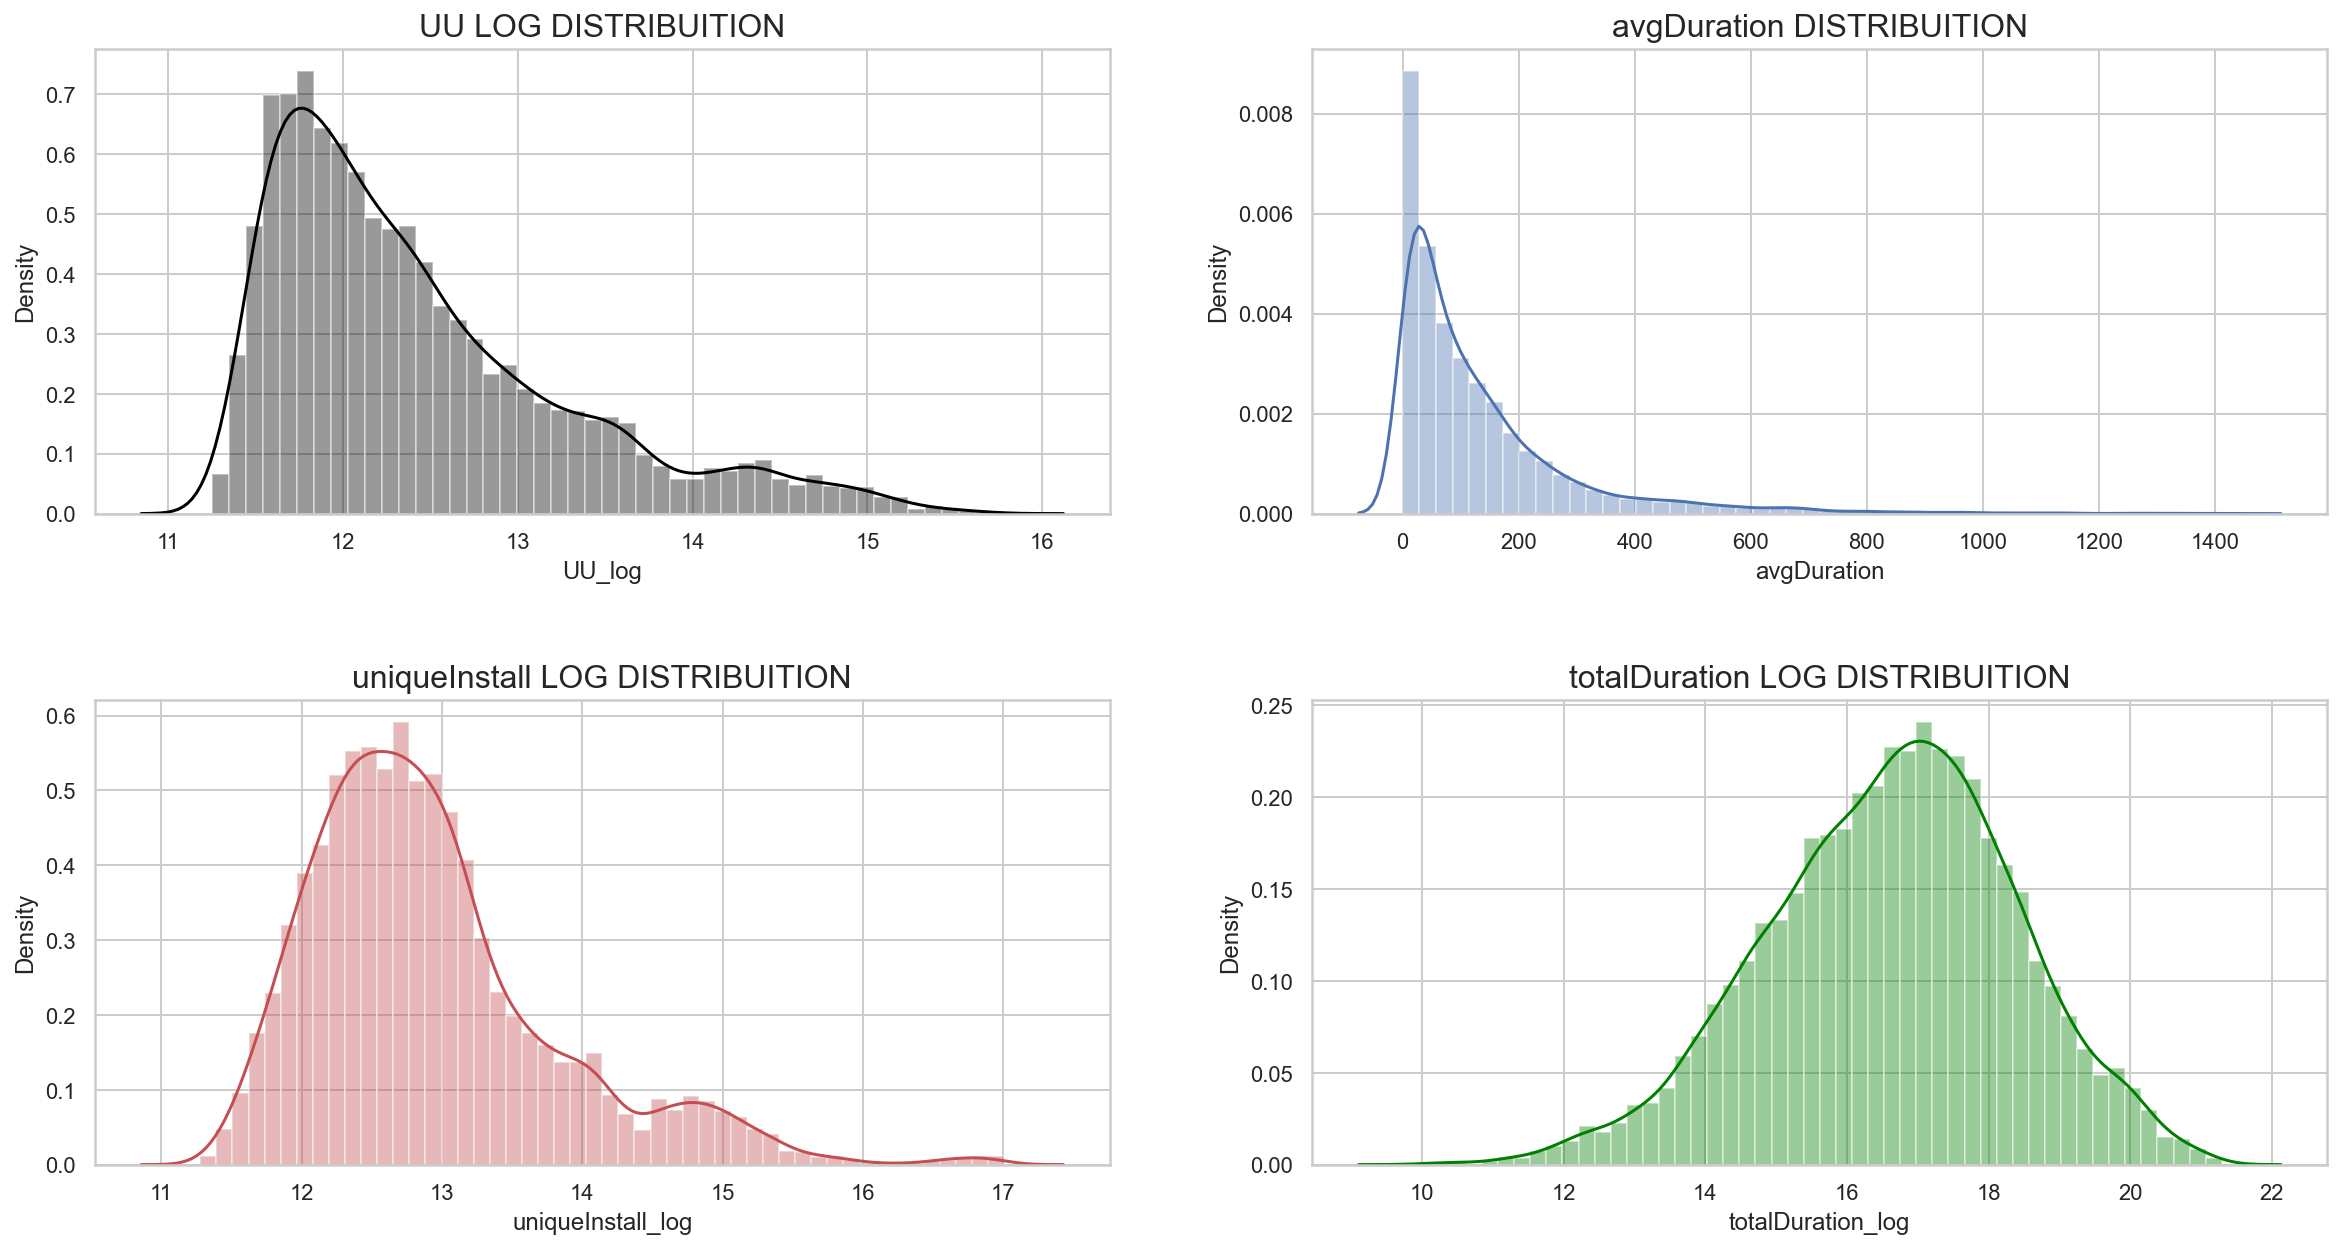

In [63]:
# 각 그래프를 통해 분포를 살펴보자.

# 수치가 큰 값들을 로그변환
dataB['UU_log'] = np.log(dataB['UU'] + 1)
dataB['totalDuration_log'] = np.log(dataB['totalDuration'] + 1)
dataB['uniqueInstall_log'] = np.log(dataB['uniqueInstall'] + 1)

plt.figure(figsize = (20,10))

plt.subplot(221)
g1 = sns.distplot(dataB['UU_log'],color='black')
g1.set_title("UU LOG DISTRIBUITION", fontsize=16)

plt.subplot(224)
g2 = sns.distplot(dataB['totalDuration_log'],color='green')
g2.set_title('totalDuration LOG DISTRIBUITION', fontsize=16)

plt.subplot(223)
g3 = sns.distplot(dataB['uniqueInstall_log'], color='r')
g3.set_title("uniqueInstall LOG DISTRIBUITION", fontsize=16)

plt.subplot(222)
g4 = sns.distplot(dataB['avgDuration'])
g4.set_title("avgDuration DISTRIBUITION", fontsize=16)

plt.subplots_adjust(wspace = 0.2, hspace = 0.4,top = 0.9)

plt.show()

## 위 그래프 해석

### UU LOG DISTRIBUITION 그래프
- 오른쪽으로 꼬리가 긴 분포를 가지고 있으며, 직관적으로 주간 이용자 수가 많은 어플은 상위권에 랭크하는 방식임을 알 수 있다.
- 하위권 어플의 주간 이용자 수는 최상위권 어플의 주간 이용자 수보다 압도적으로 작다.

### avgDuration DISTRIBUITION 그래프
- 0 값이 가장 많은 분포이므로 Hurdle Model이나 zero-inflated Model 사용 가능
- 이러한 분포를 가지는 변수는 정규분포를 이용하는 것보다 Goodness-of-Fit을 더 높이는 특징이 있다.

### uniqueInstall LOG DISTRIBUITION 그래프
- 오른쪽으로 꼬리가 긴 분포를 가지고 있으며, UU 분포와는 다르게 봉우리 부분이 더 밀도가 있다.

### totalDuration LOG DISTRIBUITION 그래프
- 거의 정규분포를 따른다고 할 수 있다.

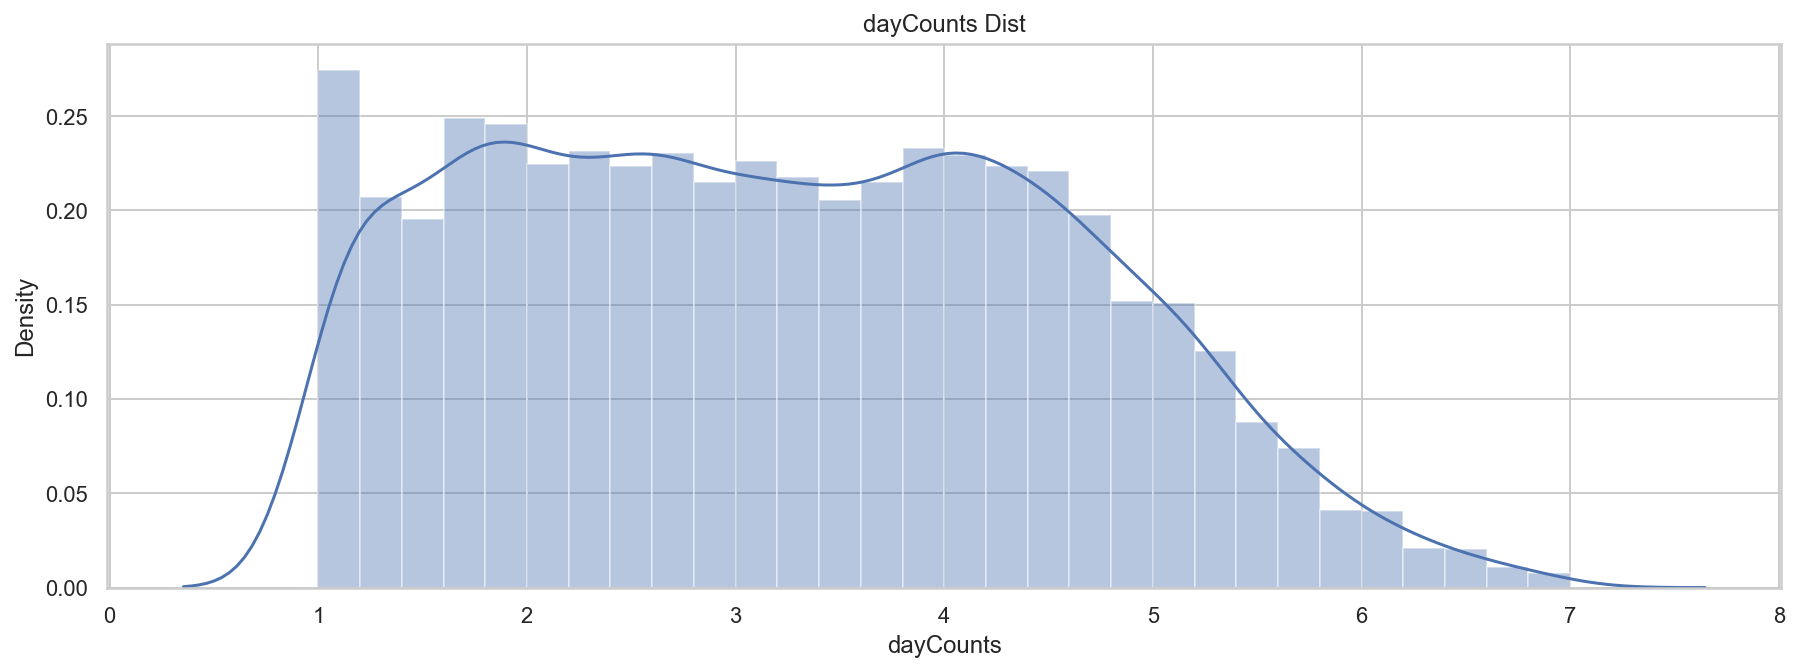

In [28]:
# 이용자당 평균 접속일수의 분포
plt.figure(figsize=(15,5))
sns.distplot(dataB.dayCounts)
plt.title("dayCounts Dist")
plt.show()

## 위 그래프 해석
- 주간분포에서는 별다른 해석보다는 이치에 맞게 하루정도 사용하는 고객이 가장 많을 것이고, 순위권에 진입한 어플이므로 일주일에 기본적으로 5~6일까지도 꾸준하게 사용하는 것으로 보인다.

Genre Name count
G04    2314
G05    1974
G03    1910
G10     998
G07     834
G06     819
G09     542
G02     504
G01     393
G08     110
Name: genreID, dtype: int64


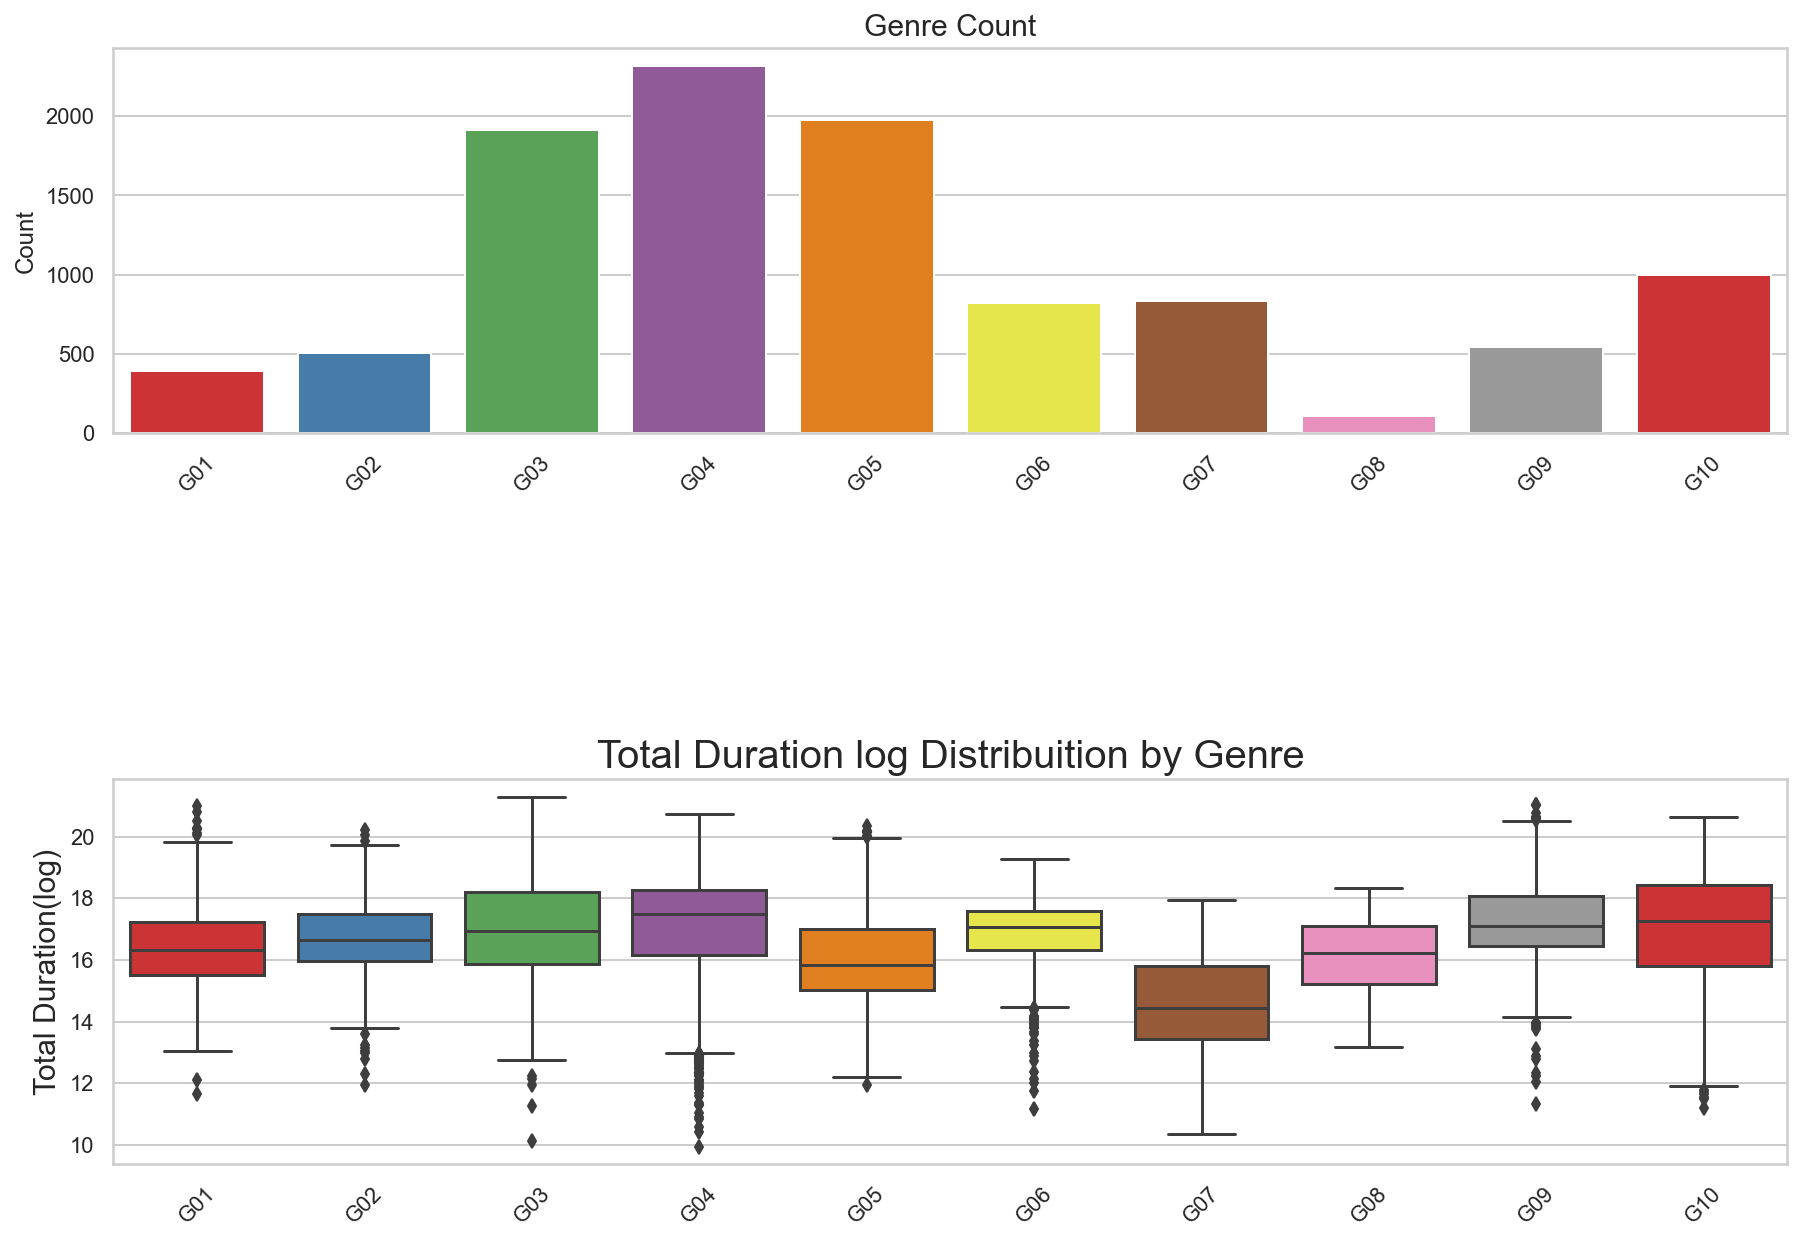

In [78]:
print("Genre Name count")
print(dataB.genreID.value_counts())

plt.figure(figsize = (15,10))

plt.subplot(211)
g = sns.countplot('genreID', data=dataB, palette="Set1")
g.set_xticklabels(g.get_xticklabels(),rotation=45)
g.set_title("Genre Count", fontsize=15)
g.set_xlabel("", fontsize=12)
g.set_ylabel("Count", fontsize=12)

plt.subplot(212)
g1 = sns.boxplot(x='genreID', y='totalDuration_log', data=dataB, palette="Set1")
g1.set_xticklabels(g.get_xticklabels(),rotation=45)
g1.set_title("Total Duration log Distribuition by Genre", fontsize=20)
g1.set_xlabel("", fontsize=15)
g1.set_ylabel("Total Duration(log)", fontsize=15)

plt.subplots_adjust(hspace = 0.9, top = 0.9)

plt.show()

## 위 그래프 해석
- 장르별 카운팅을 진행하였다. 순위권에 가장 많이 진입했던 장르는 G04이며, 그 뒤를 G05와 G03이 따랐다.
- 총 이용시간을 장르별로 나누어서 Box Plot을 통해 나타냈다.
- 순위권에 이용시간이 가장 길었던 어플이 속한 장르는 G03으로 나타났으며, 가장 짧은 어플이 속한 장르는 G04이다.
- 이는 순위권에 진입한 어플의 장르는 이용시간과 관계없이 충성도 높은 어플이 많은 장르라고 보인다. 

## EDA를 위한 그룹 생성
- 같은 날짜, 같은 장르, 같은 앱을 그룹으로 사용할 수 있다.
- 자료에서 해당 날짜의 순위는 UU(주간 이용자 수)를 기준으로 결정했음을 알 수 있다.
- UU와 그룹을 지어 생각해볼 수 있는 자료가 있을 것이다.
- 그룹은 장르, 날짜로 구분했다. 어플 고유값의 경우에는 시각화하기에 1,000여개가 넘어가기 때문에 이후 상세한 분석으로 넘어가기로한다.

In [29]:
day_mean = dataB.groupby(['day'], as_index=False)['UU'].mean()
genre_mean = dataB.groupby(['genreID'], as_index=False)['UU'].mean()

Text(0.5, 1.0, 'Day and UU mean')

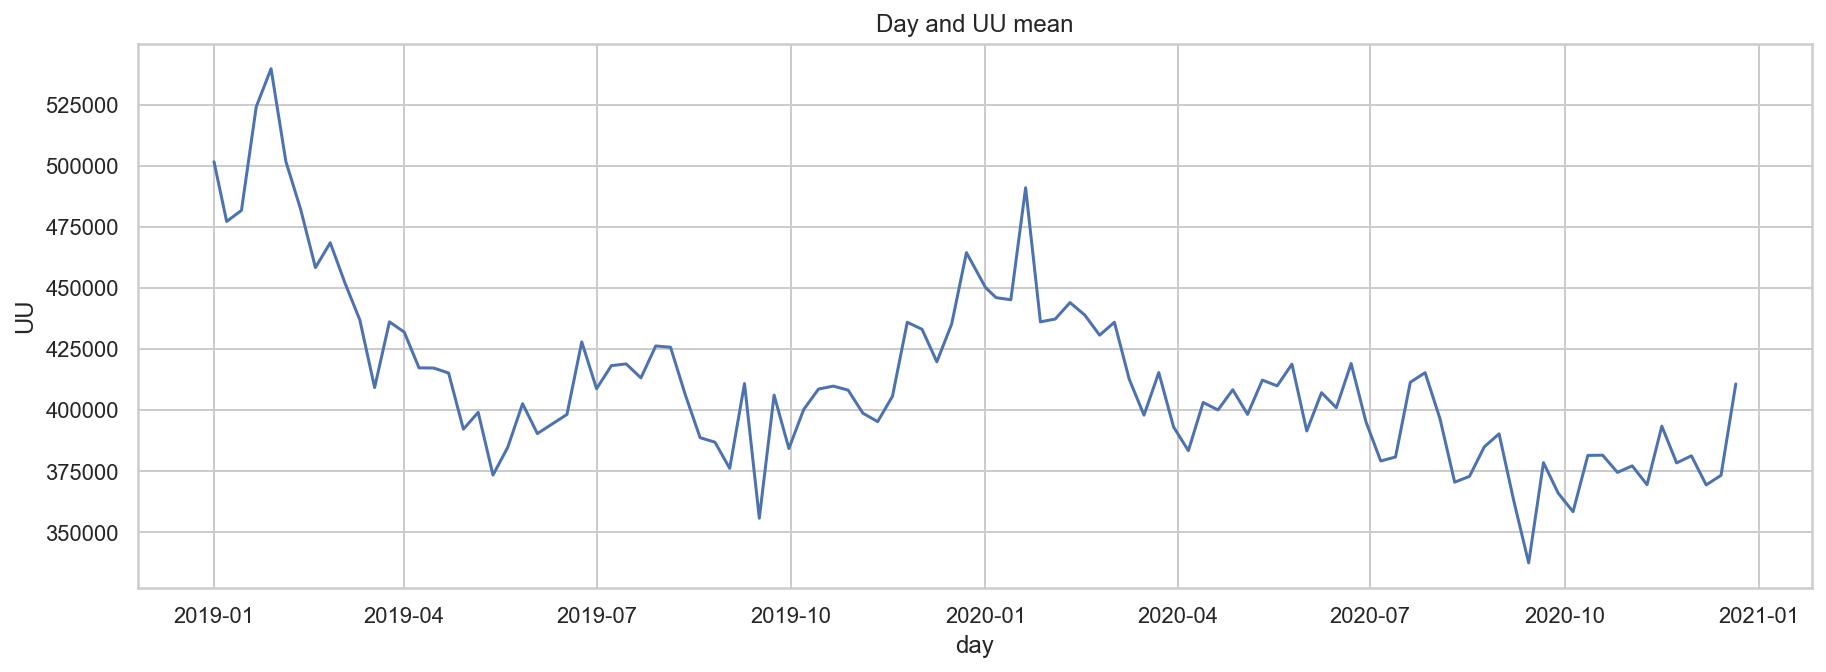

In [30]:
plt.figure(figsize=(15,5))
sns.lineplot(x="day", y="UU", data=day_mean).set_title("Day and UU mean")

## 위 그래프 해석
- 날짜의 추이로 보아서 주간 이용자 수는 연초에 급격한 증가를 보이는 것으로 보인다.
- 이는 인기 어플의 이용자들은 연초에 플레이스토어나 앱스토어 등에 더 오랫동안 머무는 것으로 판단되며, 이 때 사업성을 고려하여 이벤트를 개최할 수 있을 것이다.
- 특히, 넥슨의 경우 이번에 실시한 메이플스토리M 패스파인더 이벤트는 메이플스토리 유저의 유입을 위한 아이템 제공하는 이벤트를 실시하였으며, 유입이 상당히 많았을 것으로 예상된다.
- 실제로 어플스토어에 관심이 증가하는 2019년 연말에 V4를 출시하는 등 다양한 이벤트로 유저의 유입을 효과적으로 진행하고 있다는 점이 인상적이다.

Text(0.5, 1.0, 'Day and genre mean')

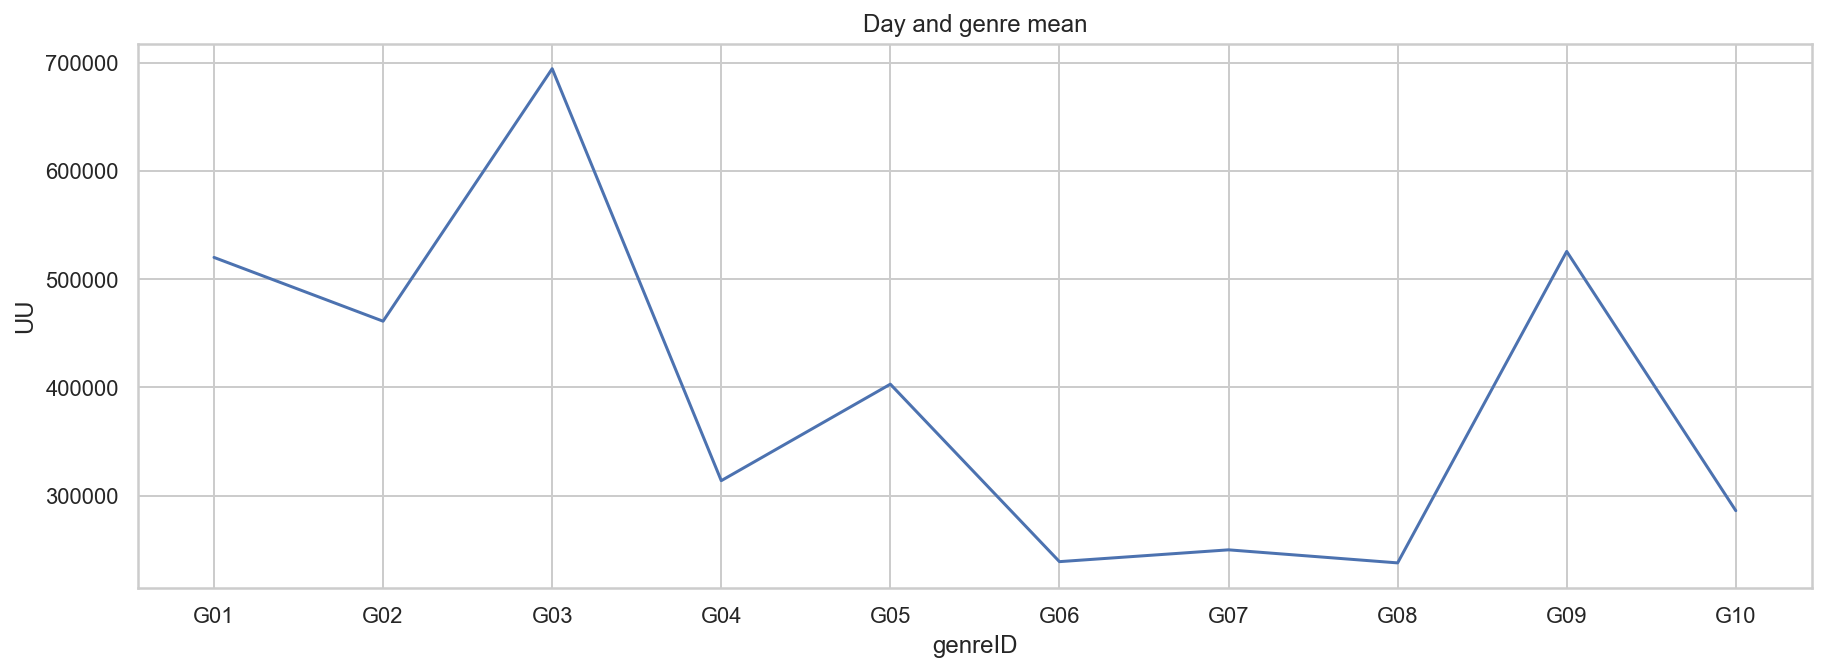

In [31]:
plt.figure(figsize=(15,5))
sns.lineplot(x="genreID", y="UU", data=genre_mean).set_title("Day and genre mean")

## 위 그래프 해석
- 가장 인기많은 장르는 G03이라고 할 수 있고, 다음은 G01과 G09가 따르고 있다. 이는 G03 장르를 개발하는 경우에 경쟁이 심화되는 우려가 있으므로 충분한 경쟁력을 갖추고, 유저의 유입을 다양한 방법으로 생각해야 할 것이다.
- 반면에 G06, G07, G08의 경우에는 점유율이 떨어지는 것으로 보여, 해당 장르에 대한 개발을 할 때 시장상황에 유의해야한다고 판단한다.

In [51]:
# 장르의 다른 접근을 위한 그룹을 생성
genre_avgDuration = dataB.groupby(['genreID'], as_index=False)['avgDuration'].mean()
genre_useRate_max = dataB.groupby(['genreID'], as_index=False)['useRate'].max()
genre_useRate_min = dataB.groupby(['genreID'], as_index=False)['useRate'].min()

Text(0.5, 1.0, 'Genre and avgDuration mean')

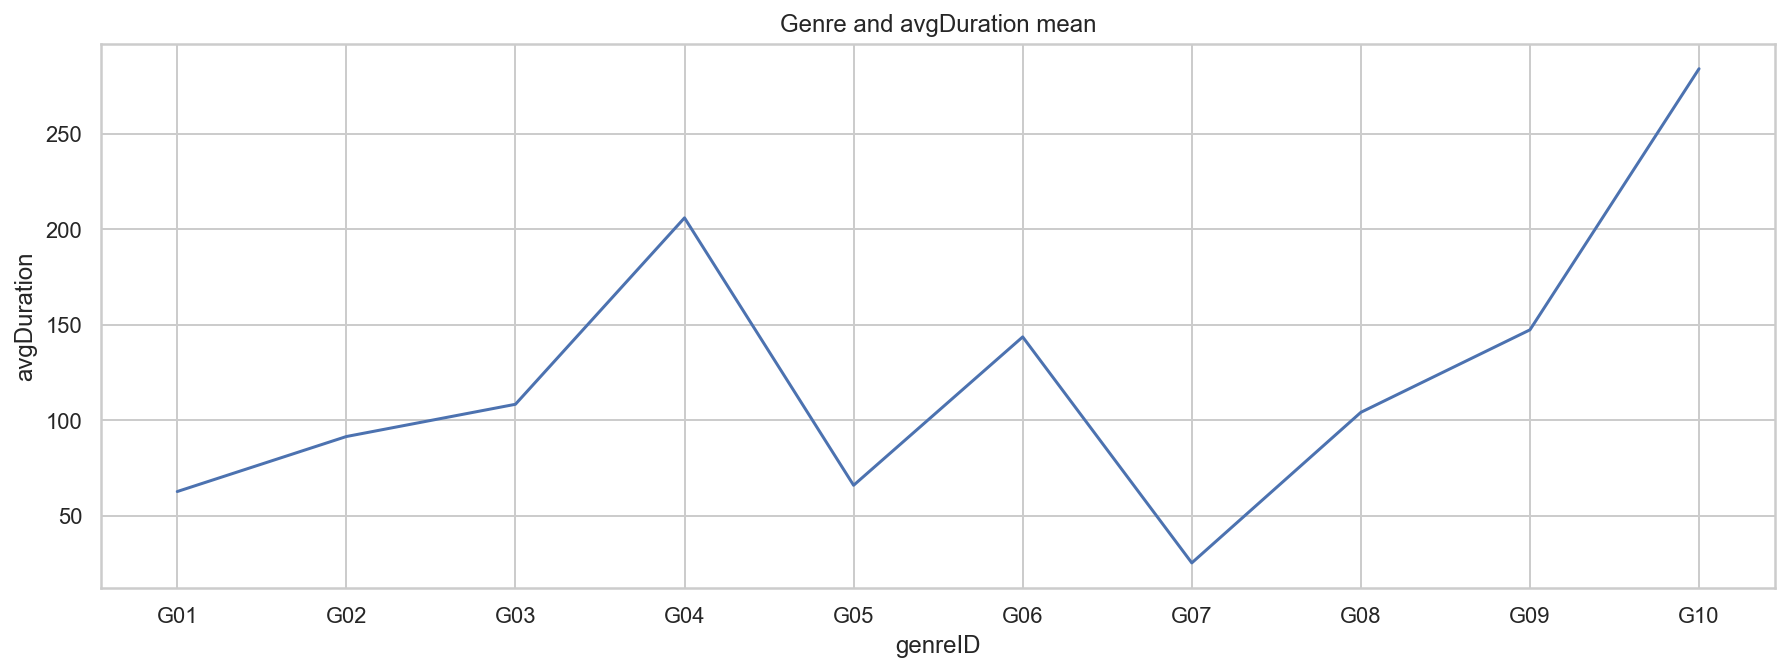

In [49]:
plt.figure(figsize=(15,5))
sns.lineplot(x="genreID", y="avgDuration", data=genre_avgDuration).set_title("Genre and avgDuration mean")

## 위 그래프 해석
- 장르에 따라 이용자의 평균 이용시간이 차이가 날 수 있음을 알 수 있다.
- 이는 주간 이용자수가 낮은 장르에 속하는 G10의 경우에 평균 이용시간이 가장 높은 것으로 보이는 것이 흥미롭다.
- 이를 통해 G10의 경우에는 주간 순위가 낮더라도 해당 장르를 설치하는 이용자의 경우 충성도있게 꾸준이 어플에 접속한 시간이 많음을 알 수 있다. 경험상 이러한 어플은 음악, 증권서비스와 같은 종류일 것이다.
- 반대로 G03 장르의 경우에는 평균 주간 이용자 수가 가장 높았지만, 이용시간은 낮은 수치를 보이고 있다. 경험상 이러한 어플은 오래 머물지 않아도 되지만 필수적인 어플이라고 보여진다. 예를들어, 금융서비스나 배달플랫폼 등과 같은 종류일 것이다.

Text(0.5, 1.0, 'Genre and useRate MAX')

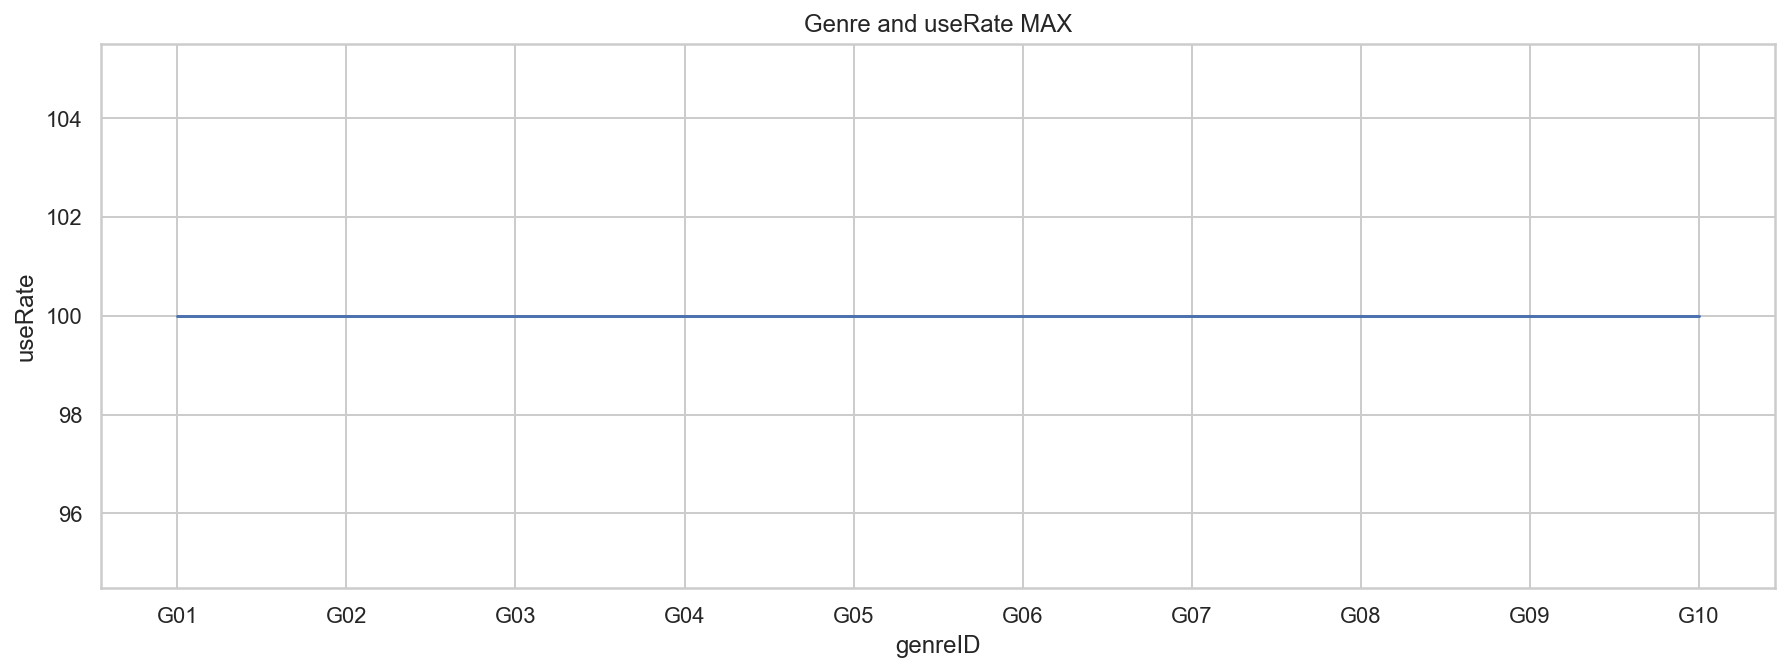

In [50]:
plt.figure(figsize=(15,5))
sns.lineplot(x="genreID", y="useRate", data=genre_useRate_max).set_title("Genre and useRate MAX")

## 위 그래프 해석
- 장르별로 어플을 설치했을 때 무조건 이용하는 어플이 모두 존재한다.

Text(0.5, 1.0, 'Genre and useRate MIN')

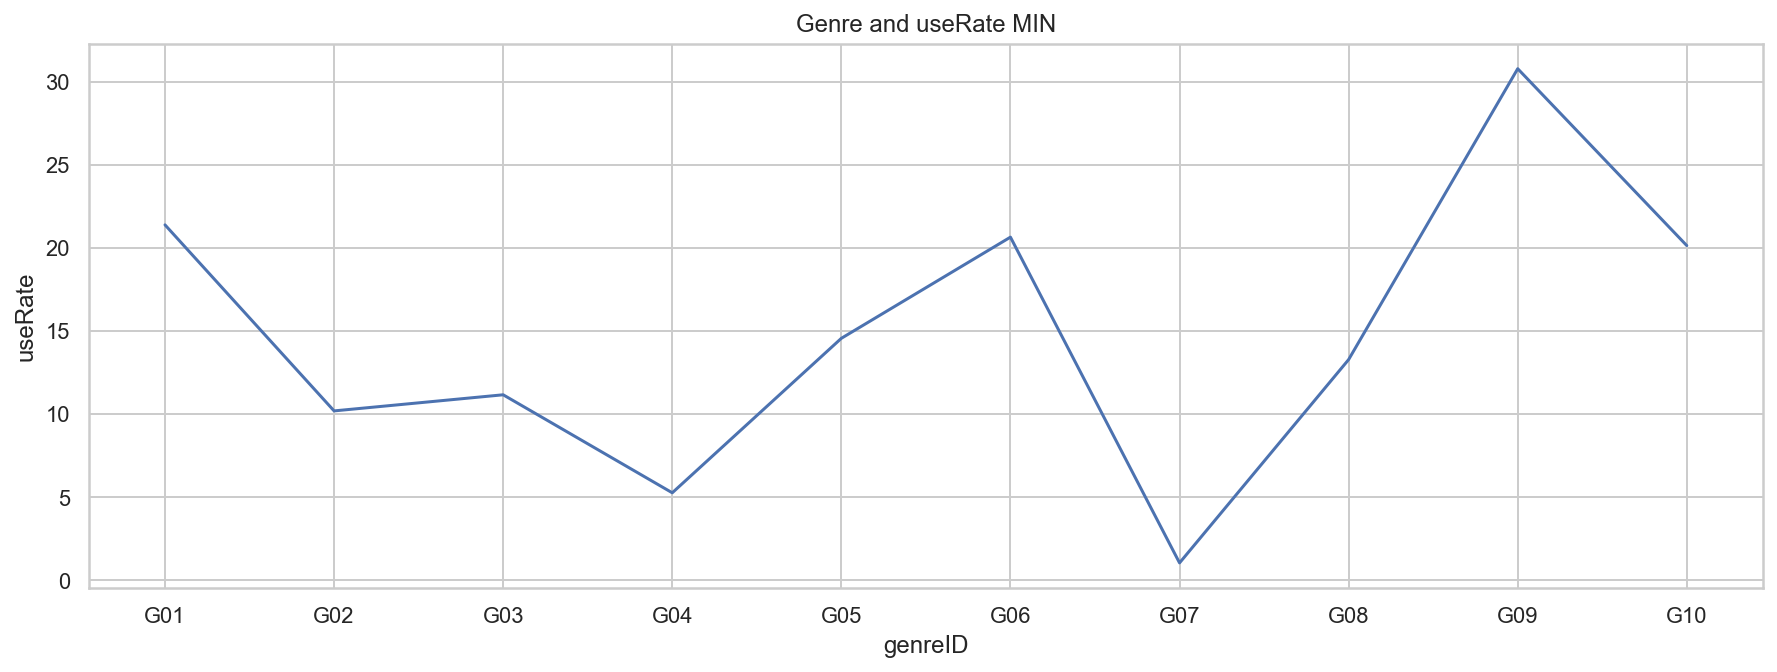

In [52]:
plt.figure(figsize=(15,5))
sns.lineplot(x="genreID", y="useRate", data=genre_useRate_min).set_title("Genre and useRate MIN")

## 위 그래프 해석
- 장르별로 어플을 설치했음에도 불구하고 거의 사용하지 않는 장르는 G07이다. 이러한 어플은 유저들과 본 장르가 스마트폰에서의 접근성을 개선할 필요가 있어보인다.
- G09의 경우에는 가장 높은 수치를 보이고 있다. 이는 G09장르를 설치했을 때, 항상 30% 이상의 유저는 사용한다는 것을 알 수 있다.

## 이상치 확인 및 제거
- 본격적인 분석하기에 앞서 데이터에 이상값이 있는지 Boxplot으로 확인한다.
- 통계적으로 IQR(울타리)을 기준으로 이상치를 확인하는 방법이다. 이때 울타리를 벗어나는 값을 이상값이라고 판단한다.

In [32]:
from collections import Counter

def detect_outliers(df, n, features):
    outlier_indices = [] 
    for col in features: 
        Q1 = np.percentile(df[col], 25) 
        Q3 = np.percentile(df[col], 75) 
        IQR = Q3 - Q1 
        outlier_step = 1.5 * IQR 
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_list_col)
        
    outlier_indices = Counter(outlier_indices) 
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)
    
    return multiple_outliers 

In [33]:
Outliers_to_drop = detect_outliers(day_mean, 2, ["UU"])
Outliers_to_drop = detect_outliers(genre_mean, 2, ["UU"])

In [34]:
day_mean.loc[Outliers_to_drop]

,day,UU


In [35]:
genre_mean.loc[Outliers_to_drop]

,genreID,UU


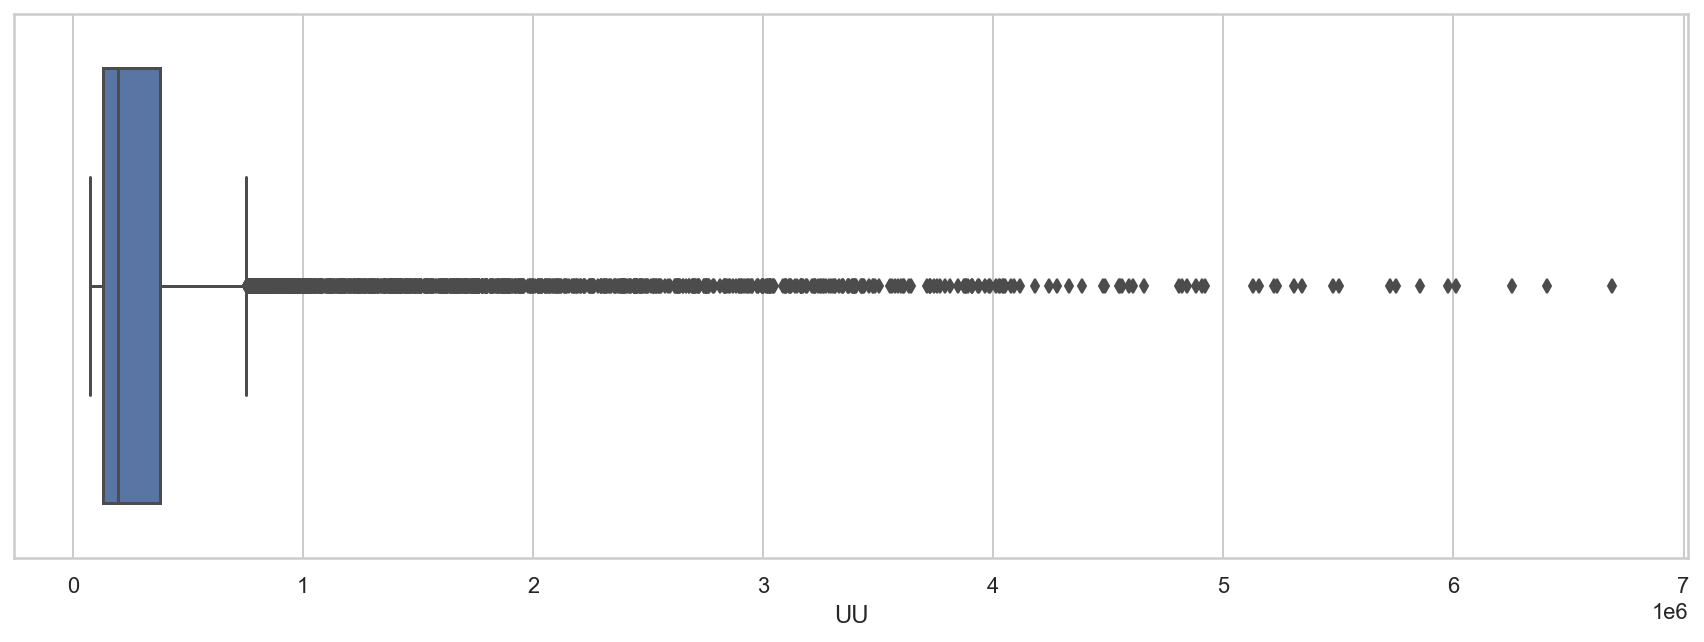

In [36]:
plt.figure(figsize=(15,5))
sns.boxplot(dataB['UU'])
plt.show()

## 위 함수 및 그래프 결과해석
- 기준치를 넘어가는 이상치는 없는 것으로 보인다.
- 이후 다른 변수들간의 관계를 고려해서 계속해서 진행할 예정이다.